# Introduction à l'apprentissage par renforcement
# TP 1 - le bandit-manchot multi-bras

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

# Définition des vaccins

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class ArmBernoulli:
    def __init__(self, p: float, random_state: int = 0):
        """
        Bernoulli arm
        Args:
             p (float): mean parameter
             random_state (int): seed to make experiments reproducible
        """
        self.mean = p
        self.local_random = np.random.RandomState(random_state)
        
    def sample(self):
        return self.local_random.rand() < self.mean

    
K = 5
T = 100
np.random.seed(1)
means = np.random.random(K)
MAB = [ArmBernoulli(m) for m in means]
assert(MAB[0].mean == means[0])

**Vaccins :** ils sont notés $A_k\leq K$, leur probabilité d'immunisation est $p_k = \mu_k$.

**Récompense :** $r_t$ vaut 1 si le patient $t$ est immunisé et 0 sinon.

**Action optimale :** choisir le vaccin $a$ avec la meilleure probabilité $a^* = \arg\max_{a\leq K} \mu_{a}$.

**Regret :** $R_T =T\mu_a^* - \mathbb{E} \left[ \sum_{t=1}^T r_t \right]$
En notant $N_a(t)$, le nombre de fois que le vaccin $a$ a été choisi jusqu'à $t$ et $\Delta_a = \mu_a^* - \mu_a$, le regret s'exprime :

$$R_T = \sum_{a=1}^K \Delta_a \mathbb{E} \left[ N_{a_T} \right]$$

<!-- #endregion -->

**Expliquez ce que signifie le regret concrètement. Pourquoi minimiser le regret donne une bonne solution au problème du bandit-manchot**

Le regret mesure la différence entre ce qu’on aurait gagné si on avait toujours
choisi le meilleur vaccin (celui avec la plus forte probabilité d’immunisation)
et ce qu’on a réellement gagné avec l’algorithme.

- le regret est grand - on a perdu beaucoup d’opportunités (on
a trop exploré de mauvais vaccins).

- le regret est petit - l’algorithme a presque toujours
choisi le meilleur vaccin.

Minimiser le regret garantit donc qu’au fur et à mesure du temps, notre
stratégie s’approche du choix optimal.

# Solution naive

 La solution naive consiste en 2 étapes distinctes :

1. Entraînement : on teste les K vaccins sur N patients et on note leur efficacité séparemment
2. Exploitation : le vaccin qui apparaît comme le meilleur est choisi pour les T-N patients restants.

**Implémentez cet algorithme avec T=100, N=20, K=5. Quel bras a été choisi lors de la seconde phase ?**

In [3]:
T = 100
N = 20
K = 5
np.random.seed(1)
means = np.random.random(K)
MAB = [ArmBernoulli(m, random_state=np.random.randint(1e6)) for m in means]

def naive_algorithm(MAB, T=100, N=20):
    K = len(MAB)
    counts = np.zeros(K)
    successes = np.zeros(K)
    rewards = []
    choices = []

    # exploration
    for t in range(N):
        a = t % K
        r = MAB[a].sample()
        rewards.append(r)
        choices.append(a)
        counts[a] += 1
        successes[a] += r

    # exploitation
    empirical_means = successes / np.maximum(1, counts)
    best_arm = np.argmax(empirical_means)
    for t in range(N, T):
        r = MAB[best_arm].sample()
        rewards.append(r)
        choices.append(best_arm)

    return np.array(rewards), np.array(choices), best_arm

rewards, choices, best_arm = naive_algorithm(MAB, T=T, N=N)
print("Bras choisi lors de l’exploitation :", best_arm)

**Obtenez-vous toujours le résultat ? Testez l'algorithme avec une valeur de N plus faible. Qu'en concluez-vous ?**

In [ ]:
for N in [5, 10, 20]:
    rewards, choices, best_arm = naive_algorithm(MAB, T=100, N=N)
    print(f"N={N}, bras choisi : {best_arm}")

Plus N est petit, plus on risque de se tromper car les estimations empiriques sont trop bruitées.
Quand N augmente, l’algorithme identifie mieux le vrai bras optimal.

**Tracez l'évolution du regret $r_t$ de votre algorithme en fonction du
résultat obtenu avec le patient $t<T$ sur plusieurs expériences. Représentez
l'évolution moyenne de ce regret sur plusieurs expériences.**

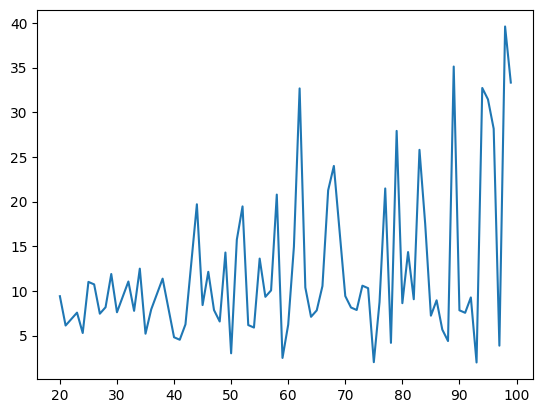

In [9]:
def cumulative_regret(means, rewards):
    mu_star = np.max(means)
    T = len(rewards)
    cum_reward = np.cumsum(rewards)
    optimal = mu_star * np.arange(1, T+1)
    return optimal - cum_reward

n_experiments = 200
regrets = []

for exp in range(n_experiments):
    np.random.seed(exp)
    MAB = [ArmBernoulli(m, random_state=np.random.randint(1e6)) for m in means]
    rewards, _, _ = naive_algorithm(MAB, T=T, N=20)
    regrets.append(cumulative_regret(means, rewards))

mean_regret = np.mean(regrets, axis=0)

plt.figure(figsize=(8,5))
plt.plot(mean_regret)
plt.xlabel("t")
plt.ylabel("Regret cumulé")
plt.show()


## Upper Confidence Bounds (P. Auer, 2002)

L'action $a_t$ l'instant $t$ est donnée par : 

$$a_t = max_a \left[ X_t(a) + B_t(a) \right]$$

où $X_t(a)$ est la moyenne empirique de la récompense obtenue avec le vaccin $a$ et $B_t(a)$ est un biais :

$$B_t(a) = \sqrt{ \frac{2\log t}{T_a}}$$ où $T_a$ est le nombre de fois que le vaccin $a$ a été choisi.

**Pourquoi cet algorithme n'a pas besoin d'une phase d'entraînement ? Quel terme favorise l'exploration et quel terme favorise l'exploitation ?**

L’algorithme commence par jouer tous les bras au moins une fois, puis

À chaque étape, on choisit le bras qui maximise :

$$estimation empirique + bonus d’exploration$$

$X_t(a)$ (moyenne empirique) favorise l’exploitation (choisir le meilleur selon ce qu’on sait).

$B_t(a)$ (bonus décroissant) favorise l’exploration (tester les bras incertains).

**Implémentez l'algorithme et tracez l'évolution du regret à partir de cet algorithme.**

In [ ]:
def ucb_algorithm(MAB, T=100):
    K = len(MAB)
    counts = np.zeros(K)
    successes = np.zeros(K)
    rewards = []
    choices = []

    for a in range(K):
        r = MAB[a].sample()
        rewards.append(r)
        choices.append(a)
        counts[a] += 1
        successes[a] += r

    for t in range(K, T):
        empirical = successes / counts
        bonus = np.sqrt(2 * np.log(t+1) / counts)
        ucb = empirical + bonus
        a = np.argmax(ucb)
        r = MAB[a].sample()
        rewards.append(r)
        choices.append(a)
        counts[a] += 1
        successes[a] += r

    return np.array(rewards), np.array(choices)

np.random.seed(1)
MAB = [ArmBernoulli(m, random_state=np.random.randint(1e6)) for m in means]
rewards_ucb, choices_ucb = ucb_algorithm(MAB, T=T)
regret_ucb = cumulative_regret(means, rewards_ucb)

plt.figure(figsize=(8,5))
plt.plot(regret_ucb)
plt.xlabel("t")
plt.ylabel("Regret cumulé")
plt.show()

**Créez une animation avec matplotlib qui permette de visualiser l'évolution des valeurs de $(X_a)_a$ et de $(B_a)_a$ au cours du temps**

Ici, c'est à vous de réfléchir à la meilleure représentation de ces valeurs.

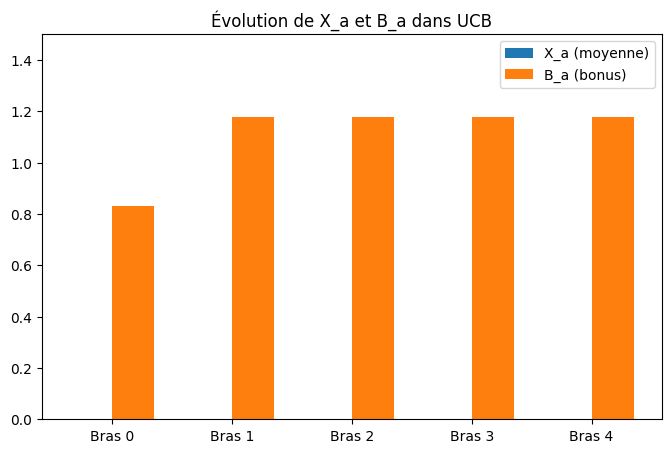

In [10]:
import matplotlib.animation as animation

def ucb_with_tracking(MAB, T=100):
    K = len(MAB)
    counts = np.ones(K)
    successes = np.zeros(K)

    history_empirical = []
    history_bonus = []
    history_choices = []

    # Jouer chaque bras une fois
    for a in range(K):
        r = MAB[a].sample()
        counts[a] += 1
        successes[a] += r
        history_empirical.append(successes / counts)
        history_bonus.append(np.sqrt(2 * np.log(a+2) / counts))
        history_choices.append(a)

    # Boucle principale
    for t in range(K, T):
        empirical = successes / counts
        bonus = np.sqrt(2 * np.log(t+1) / counts)
        ucb = empirical + bonus
        a = np.argmax(ucb)
        r = MAB[a].sample()
        counts[a] += 1
        successes[a] += r

        history_empirical.append(successes / counts)
        history_bonus.append(bonus)
        history_choices.append(a)

    return history_empirical, history_bonus, history_choices


# Construire historique
np.random.seed(1)
MAB = [ArmBernoulli(m, random_state=np.random.randint(1e6)) for m in means]
empirical_hist, bonus_hist, choices_hist = ucb_with_tracking(MAB, T=50)


# Animation matplotlib
fig, ax = plt.subplots(figsize=(8,5))
K = len(means)
x = np.arange(K)
bar_width = 0.35

bars_emp = ax.bar(x - bar_width/2, empirical_hist[0], bar_width, label="X_a (moyenne)")
bars_bonus = ax.bar(x + bar_width/2, bonus_hist[0], bar_width, label="B_a (bonus)")

ax.set_ylim(0, 1.5)
ax.set_xticks(x)
ax.set_xticklabels([f"Bras {i}" for i in range(K)])
ax.legend()
ax.set_title("Évolution de X_a et B_a dans UCB")

def update(frame):
    for i, b in enumerate(bars_emp):
        b.set_height(empirical_hist[frame][i])
    for i, b in enumerate(bars_bonus):
        b.set_height(bonus_hist[frame][i])
    ax.set_title(f"Évolution de X_a et B_a (t={frame+1})")
    return bars_emp + bars_bonus

ani = animation.FuncAnimation(fig, update, frames=len(empirical_hist),
                              interval=300, blit=False)

plt.show()


# Echantillonnage de Thomson

L'algorithme de Thompson calcule à chaque instant $t$ le paramètre des lois
Beta pour tous les vaccins. Il échantillonne alors une probabilité de choisir
chaque vaccin et choisit le vaccin avec la plus grande probabilité.

**Comment fonctionnent les lois Beta ? Comment les mettre à jour selon les résultats des vaccins ?**

La loi $Beta(\alpha, \beta)$ est une distribution sur $[0,1]$, souvent utilisée comme loi a priori pour une probabilité inconnue (ex. efficacité d’un vaccin).
Si un bras réussit ($r=1$), on met à jour : $\alpha \leftarrow \alpha+1$.
Si un bras échoue ($r=0$), on met à jour : $\beta \leftarrow \beta+1$.

Ainsi, chaque bras a une distribution Beta qui représente notre incertitude sur son efficacité.

**Comment se passent l'exploration et l'exploitation ?**

- On échantillonne une probabilité depuis la loi Beta de chaque bras.
- On choisit le bras avec la plus grande valeur échantillonnée.
- Les bras incertains ont des distributions plus larges -> plus de chances d’être explorés.
- Les bras confirmés (avec beaucoup d’essais) ont des distributions concentrées -> exploitation.

**Implémentez l'algorithme et tracez l'évolution du regret.**

In [ ]:
def thompson_sampling(MAB, T=100):
    K = len(MAB)
    alpha = np.ones(K)
    beta = np.ones(K)
    rewards = []
    choices = []

    for t in range(T):
        samples = np.random.beta(alpha, beta)
        a = np.argmax(samples)
        r = MAB[a].sample()
        rewards.append(r)
        choices.append(a)
        alpha[a] += r
        beta[a] += 1 - r

    return np.array(rewards), np.array(choices)

np.random.seed(1)
MAB = [ArmBernoulli(m, random_state=np.random.randint(1e6)) for m in means]
rewards_th, choices_th = thompson_sampling(MAB, T=T)
regret_th = cumulative_regret(means, rewards_th)

plt.figure(figsize=(8,5))
plt.plot(regret_th)
plt.xlabel("t")
plt.ylabel("Regret cumulé")
plt.show()

**Créez une animation avec matplotlib qui permette de visualiser l'évolution des probabilités au cours du temps**

Indice : pour représenter des probabilités, on pourra utiliser des diagrammes en violons.